In [57]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
#sudo pip h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from sklearn.preprocessing import MinMaxScaler

notebookstart= time.time()

In [58]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

In [59]:
#Load data
df = pd.read_csv('final.csv', index_col = 'Month')
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 294 rows, 6 columns


,coal_price,crude_price,ngas_price,gold_price,iron_price,aud_usd_closed
Month,,,,,,
1995-08-01,40.88,16.07,1.56,383.67,28.38,0.7513
1995-09-01,40.93,16.78,1.64,383.06,28.38,0.7553
1995-10-01,40.97,16.12,1.77,383.14,28.38,0.7608
1995-11-01,39.59,16.88,2.04,385.31,28.38,0.7438
1995-12-01,39.35,17.96,2.71,387.44,28.38,0.7428


In [60]:
# Check for null values
print(df.isnull().any())

coal_price        False
crude_price       False
ngas_price        False
gold_price        False
iron_price        False
aud_usd_closed    False
dtype: bool


In [61]:
#split data
train_size = int(len(df)*0.80)
test_size = len(df)-train_size

train,test = df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(len(train),len(test))

235 59


In [62]:
# Feature Scaling
from sklearn.preprocessing import RobustScaler

F_col = ['coal_price', 'crude_price','ngas_price','gold_price','iron_price']

Rs = MinMaxScaler()
Rs_t = MinMaxScaler()

Rs = Rs.fit(train[F_col].to_numpy())
Rs_t = Rs_t.fit(train[['aud_usd_closed']])

train.loc[:,F_col] = Rs.transform(train[F_col].to_numpy())
train['aud_usd_closed'] = Rs_t.transform(train[['aud_usd_closed']])


test.loc[:,F_col] = Rs.transform(test[F_col].to_numpy())
test['aud_usd_closed'] = Rs_t.transform(test[['aud_usd_closed']])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [63]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [64]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.aud_usd_closed, time_steps)
X_test, y_test = create_dataset(test, test.aud_usd_closed, time_steps)

print(X_train.shape, y_test.shape)


(225, 10, 6) (49,)


In [65]:
X_test.view()

array([[[0.26947702, 0.37067784, 0.10367893, 0.60851813, 0.17967321,
         0.44829832],
        [0.21546751, 0.39969372, 0.08528428, 0.6219081 , 0.14563794,
         0.49666178],
        [0.24684628, 0.44136375, 0.10702341, 0.62171022, 0.1929452 ,
         0.45383488],
        ...,
        [0.20291601, 0.3088579 , 0.06354515, 0.595735  , 0.15059282,
         0.37208924],
        [0.19156894, 0.27903603, 0.04347826, 0.54770919, 0.1136672 ,
         0.38658199],
        [0.18992076, 0.22503425, 0.03010033, 0.54065143, 0.07615171,
         0.39504967]],

       [[0.21546751, 0.39969372, 0.08528428, 0.6219081 , 0.14563794,
         0.49666178],
        [0.24684628, 0.44136375, 0.10702341, 0.62171022, 0.1929452 ,
         0.45383488],
        [0.23270998, 0.42347062, 0.10117057, 0.6104112 , 0.20668908,
         0.464908  ],
        ...,
        [0.19156894, 0.27903603, 0.04347826, 0.54770919, 0.1136672 ,
         0.38658199],
        [0.18992076, 0.22503425, 0.03010033, 0.54065143, 0.076

In [66]:
model = keras.Sequential()
model.add(
    keras.layers.LSTM(
      units=32, 
      input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = False
    )
  )

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1,kernel_regularizer='l1'))
model.compile(loss='mean_squared_error', optimizer='SGD', metrics = ['mse'])

In [67]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=14,
    #steps_per_epoch = 12,
    callbacks = early_stopping,
    validation_split= 0.2,
    shuffle=False
)

Epoch 1/20
13/13 [==============================] - 1s 67ms/step - loss: 0.2639 - mse: 0.1917 - val_loss: 0.4808 - val_mse: 0.4094
Epoch 2/20
13/13 [==============================] - 0s 11ms/step - loss: 0.1373 - mse: 0.0661 - val_loss: 0.2811 - val_mse: 0.2102
Epoch 3/20
13/13 [==============================] - 0s 11ms/step - loss: 0.1186 - mse: 0.0480 - val_loss: 0.2107 - val_mse: 0.1404
Epoch 4/20
13/13 [==============================] - 0s 10ms/step - loss: 0.1132 - mse: 0.0432 - val_loss: 0.1787 - val_mse: 0.1088
Epoch 5/20
13/13 [==============================] - 0s 10ms/step - loss: 0.1119 - mse: 0.0423 - val_loss: 0.1619 - val_mse: 0.0924
Epoch 6/20
13/13 [==============================] - 0s 10ms/step - loss: 0.1073 - mse: 0.0381 - val_loss: 0.1465 - val_mse: 0.0774
Epoch 7/20
13/13 [==============================] - 0s 10ms/step - loss: 0.1039 - mse: 0.0351 - val_loss: 0.1365 - val_mse: 0.0678
Epoch 8/20
13/13 [==============================] - 0s 10ms/step - loss: 0.1000 - m

In [68]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


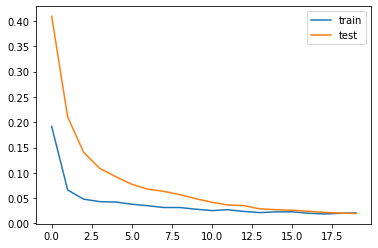

In [71]:
# plot performance
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend();

In [16]:
X_test.view()


array([[[0.26947702, 0.37067784, 0.10367893, 0.60851813, 0.17967321,
         0.44829832],
        [0.21546751, 0.39969372, 0.08528428, 0.6219081 , 0.14563794,
         0.49666178],
        [0.24684628, 0.44136375, 0.10702341, 0.62171022, 0.1929452 ,
         0.45383488],
        ...,
        [0.20291601, 0.3088579 , 0.06354515, 0.595735  , 0.15059282,
         0.37208924],
        [0.19156894, 0.27903603, 0.04347826, 0.54770919, 0.1136672 ,
         0.38658199],
        [0.18992076, 0.22503425, 0.03010033, 0.54065143, 0.07615171,
         0.39504967]],

       [[0.21546751, 0.39969372, 0.08528428, 0.6219081 , 0.14563794,
         0.49666178],
        [0.24684628, 0.44136375, 0.10702341, 0.62171022, 0.1929452 ,
         0.45383488],
        [0.23270998, 0.42347062, 0.10117057, 0.6104112 , 0.20668908,
         0.464908  ],
        ...,
        [0.19156894, 0.27903603, 0.04347826, 0.54770919, 0.1136672 ,
         0.38658199],
        [0.18992076, 0.22503425, 0.03010033, 0.54065143, 0.076

In [15]:
y_pred = model.predict(X_test)
print(y_pred.shape)

(49, 1)


In [16]:
y_train_inv = Rs_t.inverse_transform(y_train.reshape(1,-1))
y_test_inv = Rs_t.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = Rs_t.inverse_transform(y_pred)

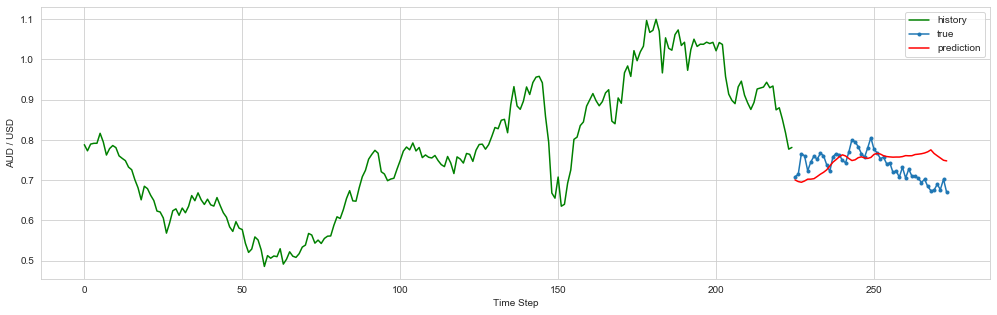

In [17]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('AUD / USD')
plt.xlabel('Time Step')
plt.legend()
plt.show();

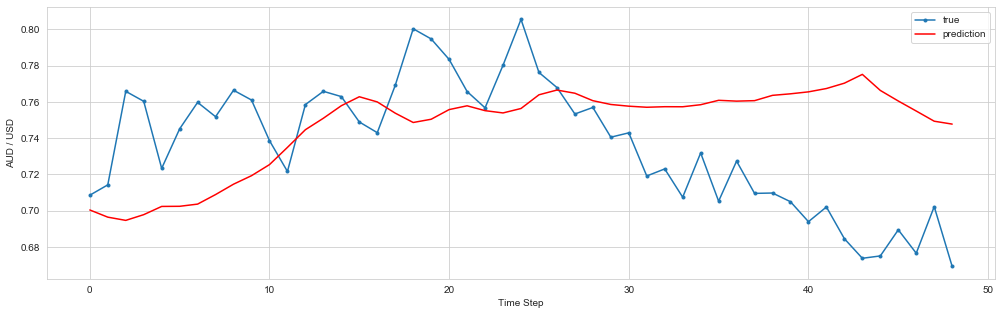

In [18]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('AUD / USD')
plt.xlabel('Time Step')
plt.legend()
plt.show();

ADD second layer

In [19]:
model2 = keras.models.Sequential()

model2.add(keras.layers.LSTM(units=32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model2.add(keras.layers.LSTM(128, activation = 'tanh',dropout = 0.4))
model2.add(keras.layers.Dense(units=1,kernel_regularizer='l1'))
model2.compile(loss='mean_squared_error', optimizer='SGD', metrics = ['mse'])

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
history2 = model2.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=14,
    #steps_per_epoch = 12,
    callbacks = early_stopping,
    validation_split= 0.2,
    shuffle=False
)

Epoch 1/30
13/13 [==============================] - 2s 123ms/step - loss: 0.2590 - mse: 0.1164 - val_loss: 0.3424 - val_mse: 0.2005
Epoch 2/30
13/13 [==============================] - 0s 20ms/step - loss: 0.1818 - mse: 0.0406 - val_loss: 0.2413 - val_mse: 0.1007
Epoch 3/30
13/13 [==============================] - 0s 20ms/step - loss: 0.1729 - mse: 0.0331 - val_loss: 0.2099 - val_mse: 0.0707
Epoch 4/30
13/13 [==============================] - 0s 20ms/step - loss: 0.1702 - mse: 0.0319 - val_loss: 0.1969 - val_mse: 0.0593
Epoch 5/30
13/13 [==============================] - 0s 20ms/step - loss: 0.1673 - mse: 0.0305 - val_loss: 0.1871 - val_mse: 0.0510
Epoch 6/30
13/13 [==============================] - 0s 20ms/step - loss: 0.1650 - mse: 0.0298 - val_loss: 0.1802 - val_mse: 0.0457
Epoch 7/30
13/13 [==============================] - 0s 19ms/step - loss: 0.1626 - mse: 0.0289 - val_loss: 0.1760 - val_mse: 0.0430
Epoch 8/30
13/13 [==============================] - 0s 20ms/step - loss: 0.1594 - 

In [34]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 32)            4992      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 87,553
Trainable params: 87,553
Non-trainable params: 0
_________________________________________________________________


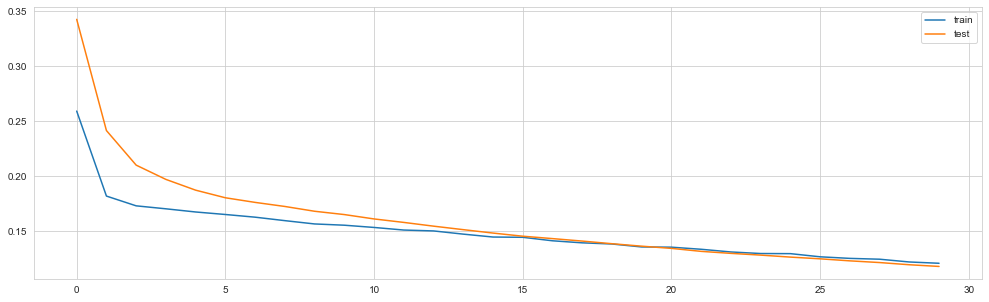

In [21]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend();

In [22]:
y_pred2 = model2.predict(X_test)
print(y_pred.shape)

(49, 1)


In [23]:
y_train_inv2 = Rs_t.inverse_transform(y_train.reshape(1,-1))
y_test_inv2 = Rs_t.inverse_transform(y_test.reshape(1,-1))
y_pred_inv2 = Rs_t.inverse_transform(y_pred2)

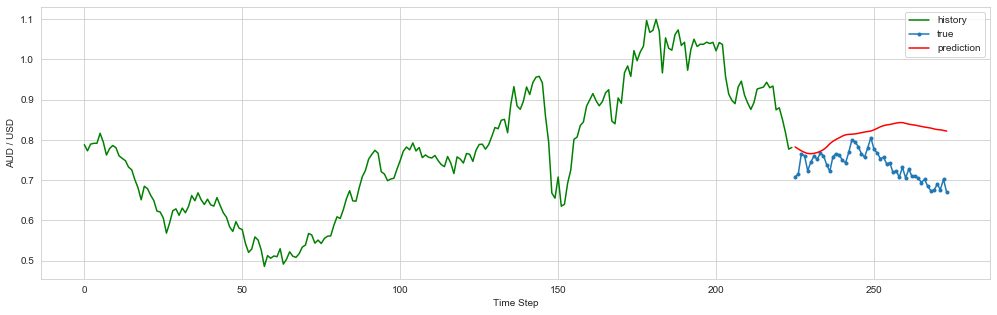

In [24]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv2.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv2.flatten(), 'r', label="prediction")
plt.ylabel('AUD / USD')
plt.xlabel('Time Step')
plt.legend()
plt.show();

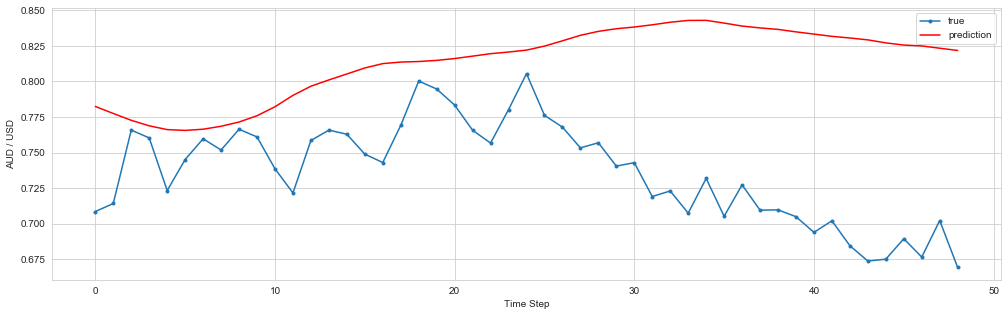

In [25]:
plt.plot(y_test_inv2.flatten(), marker='.', label="true")
plt.plot(y_pred_inv2.flatten(), 'r', label="prediction")
plt.ylabel('AUD / USD')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [76]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = (np.mean(np.abs((actual-predictions)/actual))*100)
    mae = np.mean(errors)*100
    print(model_name + ':')
    
    #print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    #print('Mean squered Error:{:.4f}'.format(mse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
    print('Mean Percentage Error: {:.4f}'.format(mae))
    
evaluate_prediction(y_pred, y_test, 'LSTM 1 layer')

evaluate_prediction(y_pred2, y_test, 'LSTM 2 layer')

LSTM 1 layer:
Root Mean Square Error: 0.0700
Mean Absolute Percentage Error: 7.3146
Mean Percentage Error: 1.6086
LSTM 2 layer:
Root Mean Square Error: 0.1431
Mean Absolute Percentage Error: 16.7779
Mean Percentage Error: 12.4960
